# Autoencoders
## What are autoencoders?
Autoencoders are networks which have the same input and output. A set of data is fed to these networks and they are expected to recreate the input. However, what makes autoencoders interesting is that they compress the information into lower number of dimensions (a.k.a latent space) and then recreate the input using those dimensions. They can be used for dimensionality reduction similar to PCA, t-SNE, and Umap. Some of the advantages of using autoencoders compared to some of the other techniques are:
- Flexibility: You can design the network based on what the problem demands.
- Reversibility: Unlike methods such as t-SNE and UMAP you can convert data back to the initial space.
- Non-linearity: Unlike linear methods such as PCA, it is capable of using non-linear transformation.

<div class="alert alert-success">
Learning Objectives:
    
- How AutoEncoders compress
- How Variation Auto Encoder's use a latent space
- What is a latent Space
- using `Kullback–Leibler divergence` as a loss to measure the difference in two distributions
- Applications of Auto Encoders
</div>  

## Structure
Autoencoders have two main components:

1. Encoder: Converts data to latent space.
2. Decoder: Converts the data back from latent space to its initial space.

The architecture looks similar to the image below:
<img src='./images/nn.svg' style='height:50rem'>

We pass the input through the model and it will compress and decompress the input and returns a result. Then we compare the output of the model with the original input. To check how close the output is to the original input we use a loss function.

## Applications

Autoencoders are not only useful for dimensionality reduction. They are often used for other purposes as well, including:
1. __Denoising:__ We could add noise to the input and then feed it to the model and then compare the output with the original image (without noise). This approach will create a model which is capable of removing noise from the input.
2. __Anomaly Detection:__ When we train a model on specific set of data, the model learns how to recreate the dataset. As a result when there are uncommon instances in the data the model will not be able to recrate them very well. This behaviour is sometimes used as a technique to find anomalous data points. 
3. __Unsupervised Clustering:__ Like clustering algorithms but more flexible, able to fit complex relationships

Let's start by importing the required libraries.

In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.distributions import Normal
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

import seaborn as sns
from PIL import Image
from pathlib import Path
import numpy as np
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from deep_ml_curriculum.torchsummaryX import summary

## Problem Description
We are going to start with a simple problem. We will use MNIST dataset which is a collection of hand-written digits as 28x28 pixel images. We are going to use autoencoder to compress each image into only two values and then reconstruct the image. When the model is trained we will have a look at the reconstructed images as well as latent space values.

## Dataset and dataloader

First we need to create a `Dataset` class. The `Dataset` class reads the data from file and returns data points when we need them. The advantage of using a `Dataset` is that we can adjust it based on what we need for each problem. If we are not dealing with large amount of data we can decide to keep everything in RAM so it is ready use. But if we are dealing with a few gigabytes of data we might need to open the file only when we need them.<br>
The MNIST data set is not large so we can easily fit it into memory. In the `Dataset` class we define a few methods:
- `__init__`: What information is required to create the object and how this information is saved.
- `__len__`: Returns the number of data points (images) when we use `len()` function.
- `__getitem__`: We can define how indexing would work for this class.

We are going to define a couple of custom functions for convinience:
- `show`: to see the image.
- `sample`: which returns a random sample of the data.

In [2]:
Dataset?

In [3]:
path = Path("../../data/processed/MNIST/")

class DigitsDataset(Dataset):
    def __init__(self, path, transform=None):

        self.root_dir = Path(path)
        self.transform = transform
        data = pd.read_csv(path)
        if "label" in data.columns:
            self.x = data.drop(columns=["label"]).values.reshape((-1, 28, 28))
            self.y = data["label"].values
        else:
            self.x = data.values.reshape((-1, 28, 28))

    def __len__(self):
        """Python method for length"""
        return len(self.x)

    def __getitem__(self, idx):
        """Python method for square brackets"""
        output = self.x[int(idx)] / 255
        if self.transform:
            output = self.transform(output)
        return output

    def show(self, idx):
        plt.imshow(self.x[idx], "gray")




__Note:__ We also defined a class called `ToTensor`. This class takes an input and converts it to pytorch tensor. 

Now that we have a `Dataset` class, we can create a training and test dataset.

In [4]:
ds_train = DigitsDataset(path / "train.csv", transform=transforms.ToTensor())
ds_test = DigitsDataset(path / "test.csv", transform=transforms.ToTensor())

In [5]:
x= ds_train[0]
x.shape, x.dtype

(torch.Size([1, 28, 28]), torch.float64)

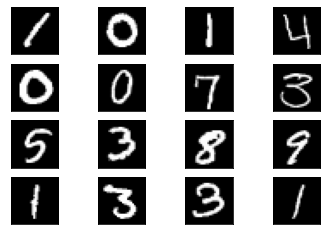

In [6]:
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, 1+i*4+j)
        ds_train.show(i*4+j)
        plt.xticks([])
        plt.yticks([])
plt.show()

In [7]:
# Both of these are the same
ds_train.__getitem__(1).shape
ds_train[1].shape

torch.Size([1, 28, 28])

Next step is to create a data loaders. The training process takes place at multiple steps. At each step, we choose a few images and feed them to the model. Then we calculate the loss value based on the output. Using the loss value we update the values in the model. We do this over and over until when we think the model is trained. Each of these steps are called a mini-batch and the number of images passed in at each mini-batch is called batch size. Dataloader's job is to go to the dataset and grab a mini-batch of images for training. To create a Dataloader we use a pytorch dataloder object.

In [8]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    ds_train, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False)
test_loader

__Note:__ Shuffle tells the data loader whether the data needs to be shuffled at the end of each epoch. We do it for training to keep the input random. But we don't need to do it for testing since we only use the test dataset for evaluation.

## Model definition

Now we need to create the model. The architecture we are going to use here is made of two linear layers for the encoder and two linear layers for the decoder.

In [9]:
# nn.Module??

In [10]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 400),
            nn.ReLU(inplace=True),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )
    def encode(self, x):
        x = x.reshape((-1, 1, 28 * 28))
        return self.encoder(x).reshape((-1, 2))

    def decode(self, z):
        return self.decoder(z).reshape((-1, 28 * 28))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

If we have access to GPU, let's make sure we are using it.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Now we create an instance of the model.

In [12]:
model = AE().to(device)
model

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [13]:
# Let use torchsummary X to see the size of the model
x=torch.rand((1, 784)).to(device)
summary(model, torch.rand((2, 784)).to(device))
1

                    Kernel Shape Output Shape    Params Mult-Adds
Layer                                                            
0_encoder.Linear_0    [784, 400]  [2, 1, 400]    314.0k    313.6k
1_encoder.ReLU_1               -  [2, 1, 400]         -         -
2_encoder.Linear_2      [400, 2]    [2, 1, 2]     802.0     800.0
3_decoder.Linear_0      [2, 400]     [2, 400]      1.2k     800.0
4_decoder.ReLU_1               -     [2, 400]         -         -
5_decoder.Linear_2    [400, 784]     [2, 784]  314.384k    313.6k
6_decoder.Sigmoid_3            -     [2, 784]         -         -
------------------------------------------------------------------
                        Totals
Total params          630.386k
Trainable params      630.386k
Non-trainable params       0.0
Mult-Adds               628.8k


1

We also need to choose an optimiser. The optimiser use the loss value and it's gradients with respect to model parameters and tells us how much each value must be adjusted to have a better model.

In [14]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

And the final component is the loss function. Here we are going to use Binary Cross Entropy function because each pixel can go from zero to one.

In [15]:
def loss_bce(recon_x, x):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    return BCE

Let's define two functions one for executing a single epoch of training and one for evaluating the mdel using test data.<br>
Notice the following comments in the training loop

In [16]:
def train(epoch, loss_function, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(tqdm(train_loader, leave=False, desc='train')):
        # We make sure the data is in the right device (cpu or gpu)
        data = data.to(device).float()
        
        # We make sure that any saved gradient (derivative) is zeroed.
        optimizer.zero_grad()
        
        # We pass a mini-batch of data into the model and grab the predictions.
        recon_batch = model(data)
        
        # We use the loss function to find out how close the model's output is to the actual image.
        loss = loss_function(recon_batch, data)
        
        # We use loss.backward() to calculate the derivative of loss with respect to model parameters.
        loss.backward()
        
        # We ask the optimiser to update model's parameters.
        optimizer.step()
        
        train_loss += loss.item()
        if batch_idx % log_interval == 0:
            pct = 100.0 * batch_idx / len(train_loader)
            l = loss.item() / len(data)
            print(
                '#{} [{}/{} ({:.0f}%)]\t Batch Loss: {:.6f}  '.format(epoch, batch_idx * len(data), len(train_loader.dataset), pct, l),
                end="\r",
                flush=True,
            )
    print('#{} Train loss: {:.4f}\t'.format(epoch, train_loss / len(train_loader.dataset)))


def test(epoch, loss_function, log_interval=50):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader, leave=False, desc='test')):
            data = data.to(device).float()
            recon_batch = model(data)
            test_loss += loss_function(recon_batch, data).item()

    test_loss /= len(test_loader.dataset)
    print('#{} Test loss: {:.4f}'.format(epoch, test_loss))

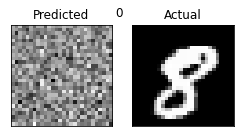

In [17]:
def cvt2image(tensor):
    return tensor.detach().cpu().numpy().reshape(28, 28)

def show_prediction(idx, title='', ds=ds_train):
    """Show a predict vs actual"""
    model.eval()
    original = ds[idx].float()
    result = model(original.to(device))
    img = cvt2image(result[0]).squeeze()
    
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(img, "gray")
    plt.title("Predicted")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.imshow(original.squeeze(), 'gray')
    plt.title("Actual")
    plt.xticks([])
    plt.yticks([])
    
    plt.suptitle(title)
    plt.show()
    
show_prediction(10, '0')

Now that all the components are ready, let's train the model for $10$ epochs.

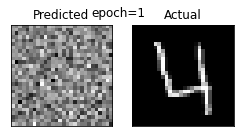

#1 Train loss: 178.8751	Batch Loss: 162.006699  


#1 Test loss: 164.1840


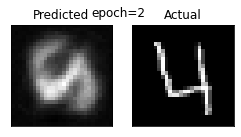

#2 Train loss: 161.1953	Batch Loss: 150.184143  


#2 Test loss: 159.0921


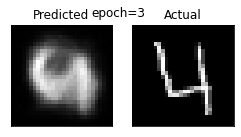

#3 Train loss: 157.3422	Batch Loss: 157.783524  


#3 Test loss: 156.1561


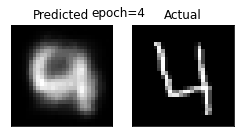

#4 Train loss: 155.0154	Batch Loss: 156.836761  


#4 Test loss: 154.0887


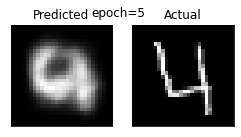

#5 Train loss: 153.1640	Batch Loss: 149.944168  


#5 Test loss: 152.3966


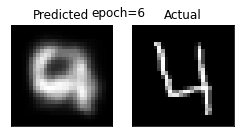

#6 Train loss: 151.6397	Batch Loss: 160.143158  


#6 Test loss: 151.7395


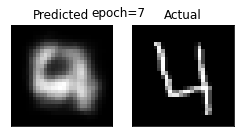

#7 Train loss: 150.5064	Batch Loss: 157.108032  


#7 Test loss: 150.7273


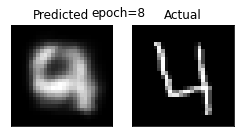

#8 Train loss: 149.4979	Batch Loss: 142.062927  


#8 Test loss: 149.8332


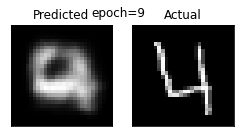

#9 Train loss: 148.6328	Batch Loss: 137.544235  


#9 Test loss: 148.9877


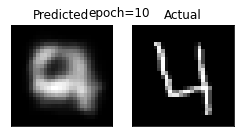

#10 Train loss: 147.9278	Batch Loss: 139.597870  


#10 Test loss: 148.6458



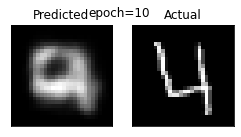

In [18]:
epochs = 10
for epoch in tqdm(range(1, epochs + 1)):
    show_prediction(3, title=f"epoch={epoch}")
    train(epoch, loss_bce)
    test(epoch, loss_bce)
show_prediction(3, title=f"epoch={epoch}")

## Results
Now let's check out the model.

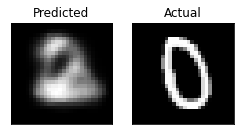

In [19]:
# Generate a random integer
idx = np.random.randint(0, len(ds_test))
# show this row of the data
show_prediction(idx)

<font color='blue' size='4rem'>Run the cell above a few times and compare the predicted and actual images.</font>

## Latent space

There are certainly some similarities but the predicted (reconstructed) images are not always very clear. We will shortly discuss how we can improve the model. But before that, let's have look at the latent space. The model is converting every image which has 784 values (28x28 pixels) to only 2 values. 

Those 2 values are the latent space. We can plot them for a few numbers (see below).

We can also traverse the latent space and see how the reconstructed image changes in meaningfull ways. This is a usefull property and means the model has learnt how to vary images.

In [20]:
# Scatter plot

def traverse(ds=ds_train, model=model, y=None, xmin=None, xmax=None):
    # Get the first 1000 images
    n = min(1000, len(ds))
    idxs = np.random.choice(range(len(ds)), size=n, replace=False)
    x = torch.stack([ds[i] for i in idxs])
    ys = np.array([ds.y[i] for i in idxs])
    x = x.to(device).float().reshape((-1, 1, 28,28))
    
    res = model.encode(x)
    
    # If we output a distribution, use the mean
    if isinstance(res, Normal):
        res = res.loc
    
    # to numpy
    res = res.detach().cpu().numpy()

    classes = pd.Series(ds.y).unique()
    for i, cls in enumerate(classes):
        idx = ys == cls
        plt.scatter(res[idx, 0], res[idx, 1], label=cls, alpha=0.5)
    plt.title('the latent space')
    plt.xlabel('latent variable 1')
    plt.ylabel('latent variable 2')
    
    if xmin is None:
        xmin, xmax = plt.xlim()
        xrange = xmax-xmin
        xmin -= xrange/2
        xmax += xrange/2
    
    if y is None:
        ymin, ymax = plt.ylim()
        y = (ymin+ymax)/2

    plt.hlines(y, xmin, xmax, color='r', lw=2, label='traversal')
    plt.legend()
    plt.show()
    
    

    # Do out traversal
    plt.figure(figsize=(12, 12))
    n_steps = 10
    xs = np.linspace(xmin, xmax, n_steps)
    for xi, x in enumerate(xs):
        # Decode image at x,y
        z = torch.zeros((1, res.shape[1]))
        z[:, 0] = x
        z[:, 1] = y
        z = z.float().to(device)
        img = model.decode(z).cpu().detach().numpy()
        img = (img.reshape((28, 28)) * 255).astype(np.uint8)
        
        # plot an image at x, y
        plt.subplot(1, n_steps, xi+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{x:2.1f}, {y:2.1f}')
        plt.xticks([])
        plt.yticks([])

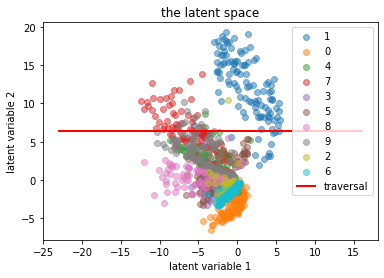

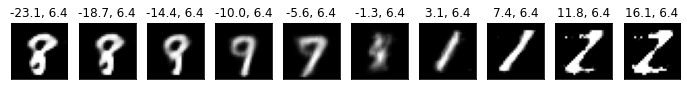

In [21]:
traverse(model=model, ds=ds_train)

Each color represents a number. Despite most numbers overlapping, we can still see some distictions, for instance between $1$ and other numbers. 

## Improving the model

Obviously the model that we trained needs improvement as it is not recreating the images well enough. 

There are a few ways we can improve the model. One way is to create a deeper encoder and decoder. In the example above we used only two layers for encoder and layers for decoder. This doesn't allow the model to comprehend complex relationships, especially in this scenario since we are working with images. By adding more layers we can give the model the opportunity to better differentiate between digits.

Another way of making the model is using more dimensions in latent space. For instance, if instead of compressing each image into two values we could use ten values. This will allow the model to extract more features from the input which will make reconstructing the image easier. However, it must be noted that whole point of using autoencoder is to force the model to compress the information into as few dimensions as possible.

# Variational Autoencoders
Variational Autoencoders (VAE) are one of the variations of autoencoders. Unlike normal autoencoders which compress the data into a few values, VAEs tries to find the distribution of the data in latent space. As a result, the final model not only has the ability to recreate the input, but can also generate new outputs by sampling from the latent space distribution.

Since VAE is a variation of autoencoder, it has a similar architecture. The main difference between the two is an additional layer between encoder and decoder which samples from latent space distribution.
In a VAE, the encoder generates two values for each parameter in latent space. One represent the mean and one represents the standard deviation of the parameter. Then sampling layer uses these two numbers and generates random values from the same distribution. These values then are fed to decoder which will create an output similar to the input.

## Model definition: VAE

Let's create a VAE model. We will use layers with the same size as the previous model. Notice for the second layer we have two linear layers, one to generate the mean and one to generate the log of variance which will be converted into standard deviation.

In [22]:
   
class VAE(nn.Module):
    """Variational Autoencoder"""
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 4) # 2 for mean, 2 for std
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        """Takes in image, output distribution"""
        x = x.reshape((-1, 28*28))
        h = self.encoder(x)
        # first few features are mean
        mean = h[:, :2]
        # second two are the log std
        log_std = h[:, 2:]
        std = torch.exp(log_std)
        # return a normal distribution with 2 parameters
        return Normal(mean, std)

    def decode(self, z):
        """Takes in latent vector and produces image."""
        return self.decoder(z).reshape((-1, 28 * 28))

    def forward(self, x):
        """Combine the above methods"""
        dist = self.encode(x.view(-1, 784))
        z = dist.rsample() # sample, with gradient
        return self.decode(z), dist

In [23]:
# Normal's
d = Normal(torch.tensor([0, 1]), torch.Tensor([2, 3]))
# d.rsample()

In [24]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [25]:
# We can view the shape of our model and number of params
x = torch.rand((1, 784)).to(device)
summary(model, x)
1

                    Kernel Shape Output Shape    Params Mult-Adds
Layer                                                            
0_encoder.Linear_0    [784, 400]     [1, 400]    314.0k    313.6k
1_encoder.ReLU_1               -     [1, 400]         -         -
2_encoder.Linear_2      [400, 4]       [1, 4]    1.604k      1.6k
3_decoder.Linear_0      [2, 400]     [1, 400]      1.2k     800.0
4_decoder.ReLU_1               -     [1, 400]         -         -
5_decoder.Linear_2    [400, 784]     [1, 784]  314.384k    313.6k
6_decoder.Sigmoid_3            -     [1, 784]         -         -
------------------------------------------------------------------
                        Totals
Total params          631.188k
Trainable params      631.188k
Non-trainable params       0.0
Mult-Adds               629.6k


1

## Concept: KLD

The loss function is similar to what we used before, except we have an extra part. the extra equation is [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) which measures difference between probability distributions.

<img width="600" src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/KL-Gauss-Example.png/800px-KL-Gauss-Example.png"/>

However we are using the KLD_loss, which is always positive

Image source: wikipedia

In [26]:
def loss_bce_kld(recon_x, x, dist):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    
    # KL-divergence between a diagonal multivariate normal,
    # and a standard normal distribution (with zero mean and unit variance)
    # In other words, we are punishing it if it's distribution moves away from a standard normal dist
    KLD = -0.5 * torch.sum(1 + dist.scale.log() - dist.loc.pow(2) - dist.scale)
    return BCE + KLD

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


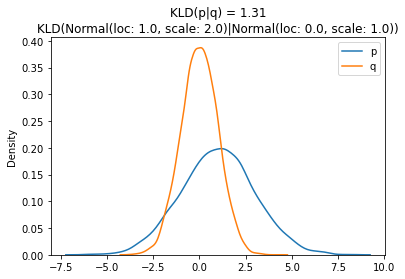

In [27]:
# You can try the KLD here with differen't distribution
p = Normal(loc=1, scale=2)
q = Normal(loc=0, scale=1)
kld = torch.distributions.kl.kl_divergence(p, q)

# plot the distributions
ps=p.sample_n(10000).numpy()
qs=q.sample_n(10000).numpy()

sns.kdeplot(ps, label='p')
sns.kdeplot(qs, label='q')
plt.title(f"KLD(p|q) = {kld:2.2f}\nKLD({p}|{q})")
plt.legend()
plt.show()

## Exercise 1: KLD

Run the above cell with while changing Q.

- Use the code above and test if the KLD is higher for distributions that overlap more

- (advanced) Write new code that plots a line of kld vs q.loc, using the function below

```python
def kld_vs_qloc(loc):
    kld = torch.distributions.kl.kl_divergence(p, Normal(loc=loc, scale=1))
    return kld
    
klds = []
locs = range(-10, 10)
for loc in locs:
    # YOUR CODE HERE: run kld_vs_qloc, for a loc
    klds.append(kld)

# YOUR code here, plot locs vs klds
```

tensor(0.) tensor(50.)
close is lower? tensor(True)


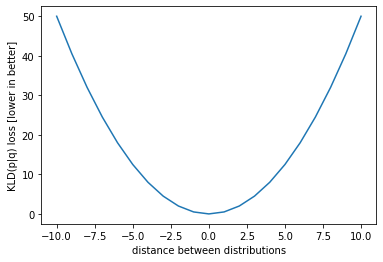

In [28]:
# Part 1
p = Normal(0, 1)
kld_close = torch.distributions.kl.kl_divergence(p, Normal(0, 1))
kld_far = torch.distributions.kl.kl_divergence(p, Normal(10, 1))
print(kld_close, kld_far)
print('close is lower?', kld_close<kld_far)

# Part 2: Plot the KLD as you vary the mean of q
p = Normal(0, 1)
means = np.arange(-10, 11)

klds=[]
for mean in means:
    q = Normal(mean, 1)
    kld = torch.distributions.kl.kl_divergence(p, q)
    klds.append(kld)

plt.plot(means, klds)
plt.ylabel('KLD(p|q) loss [lower in better]')
plt.xlabel('distance between distributions')
plt.show()

## Train

We also need to slightly adjust the training loop since the loss function now takes four inputs.

In [29]:
def train_vae(epoch, loss_function, model, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(tqdm(train_loader, leave=False)):
        data = data.to(device).float()
        optimizer.zero_grad()
        recon_batch, dist = model(data)
        loss = loss_function(recon_batch, data, dist)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            pct = 100.0 * batch_idx / len(train_loader)
            l = loss.item() / len(data)
            print(
                '#{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}  '.format(epoch, batch_idx * len(data), len(train_loader.dataset), pct, l),
                end="\r",
                flush=True,
            )
    print('#{} Train loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


def test_vae(epoch, loss_function, model, test_loader, log_interval=50):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device).float()
            recon_batch, dist = model(data)
            test_loss += loss_function(recon_batch, data, dist).item()

    test_loss /= len(test_loader.dataset)
    print('#{} Test loss: {:.4f}'.format(epoch, test_loss))

In [30]:
# We can view the shape of our model and number of params
summary(model, torch.rand((1, 784)).to(device))
1

                    Kernel Shape Output Shape    Params Mult-Adds
Layer                                                            
0_encoder.Linear_0    [784, 400]     [1, 400]    314.0k    313.6k
1_encoder.ReLU_1               -     [1, 400]         -         -
2_encoder.Linear_2      [400, 4]       [1, 4]    1.604k      1.6k
3_decoder.Linear_0      [2, 400]     [1, 400]      1.2k     800.0
4_decoder.ReLU_1               -     [1, 400]         -         -
5_decoder.Linear_2    [400, 784]     [1, 784]  314.384k    313.6k
6_decoder.Sigmoid_3            -     [1, 784]         -         -
------------------------------------------------------------------
                        Totals
Total params          631.188k
Trainable params      631.188k
Non-trainable params       0.0
Mult-Adds               629.6k


1

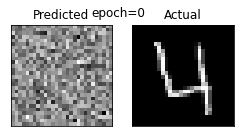

#1 Train loss: 186.8852Loss: 155.461349  
#1 Test loss: 168.6469


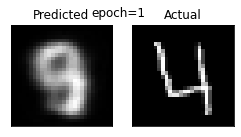

#2 Train loss: 164.9159Loss: 165.298172  
#2 Test loss: 162.6099


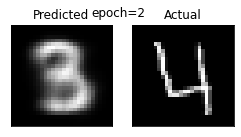

#3 Train loss: 160.8802Loss: 160.825912  
#3 Test loss: 159.6439


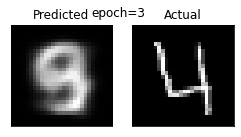

#4 Train loss: 158.6603Loss: 165.085571  
#4 Test loss: 157.6968


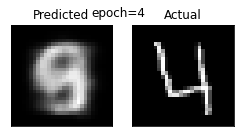

#5 Train loss: 156.9428Loss: 155.535614  
#5 Test loss: 156.6541


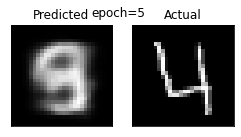

#6 Train loss: 155.5935Loss: 159.799789  
#6 Test loss: 155.2900


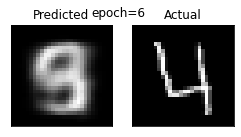

#7 Train loss: 154.3589Loss: 160.627106  
#7 Test loss: 154.0118


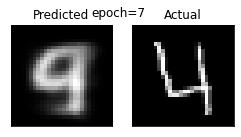

#8 Train loss: 153.3200Loss: 155.318451  
#8 Test loss: 153.3081


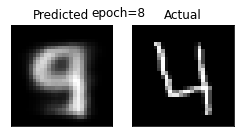

#9 Train loss: 152.3311Loss: 150.557312  
#9 Test loss: 152.4236


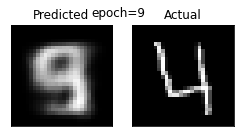

#10 Train loss: 151.5430Loss: 149.409073  
#10 Test loss: 151.9912


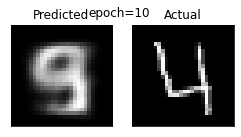

In [31]:
epochs = 10
show_prediction(3, title=f"epoch={0}")
for epoch in tqdm(range(1, epochs + 1)):
    train_vae(epoch, loss_bce_kld, model, train_loader)
    test_vae(epoch, loss_bce_kld, model, test_loader)
    show_prediction(3, title=f"epoch={epoch}")

## Saving and Loading Model

You can save and load as a pickle, but it's better to use torch.save (which uses pickle)

In [32]:
import pickle

In [33]:
with open("VAE.pk", "wb") as fp:
    torch.save(model.state_dict(), fp)

In [34]:
model = VAE().to(device)
with open("VAE.pk", "rb") as fp:
    model.load_state_dict(torch.load(fp))

## Results

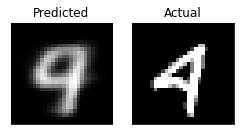

In [35]:
idx = np.random.randint(0, len(ds_test))
show_prediction(idx)

One property of a latent space is that you can travese it, and get meaningful varations of outputs.

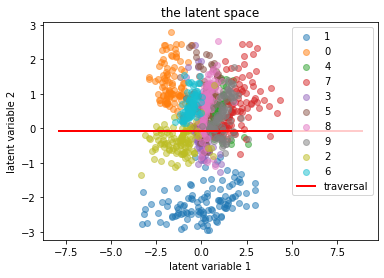

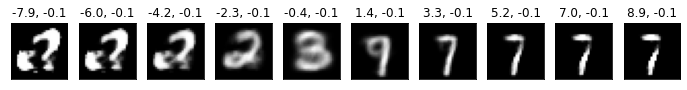

In [36]:
traverse(model=model, ds=ds_train)

If we compare this plot with the similar plot for normal autoencoder, we can see that VAE did a better job at creating clusters. The points for each digits are closer together compared to previous model. However, there is still room for improvement. 

We can also see that using KLD helped make sure the latent space was centered around 0.

## Exercise 2: Deeper
Create a new VAE but this time use a deeper network. Note, everything else (loss function, dataloaders, training loops, etc.) will stay the same only the model will change. The example above was using these sizes: 784 --> 400 --> 2 --> 400 --> 784

Try a new model which uses these size: 784 --> 400 --> 80 --> 2 --> 80 --> 400 --> 784 

In [37]:
# Create the model definition
# YOUR CODE HERE

# # Training logic
# epochs = 10
# show_prediction(10, title=f"epoch={0}")
# for epoch in tqdm(range(1, epochs + 1)):
#     train(epoch, loss_bce_kld)
#     test(epoch, loss_bce_kld)
#     show_prediction(10, title=f"epoch={epoch}")

# # Visualise the results
# idx = np.random.randint(0, len(ds_test))
# show_prediction(idx)
# plt.show()

# traverse(model=model, y=3, xmin=-5, xmax=5)

## Exercise 3: Wider
Create a new VAE but this time use a more than two parameters for the latent space. This will reduce the loss

# Application: Anomaly Detection

The model will reconstruct normal data well, and fail to reconstruct anomolies. This means we can use it for anomoly detection

img_loss=109.65, random_loss=2056.27
anomoly detected=True


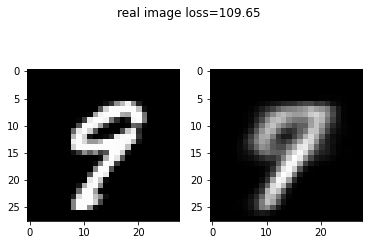

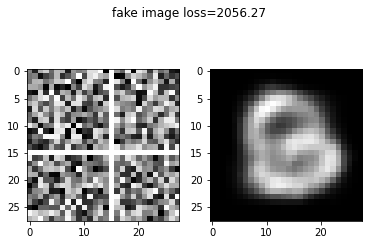

In [38]:
img = ds_train[11].to(device).float()

# First try to reconstruct a real image
img_recon, _ = model(img)
loss_img = loss_bce(img_recon , img)

# then a fake image, a vector of random noise
rand = torch.rand((28, 28)).to(device)
rand[:, 15] = 1
rand[15, :] = 1
rand = rand.reshape((-1, ))
rand_recon, _ = model(rand)
loss_rand = loss_bce(rand_recon , rand)

print(f'img_loss={loss_img:2.2f}, random_loss={loss_rand:2.2f}\nanomoly detected={loss_img<loss_rand}')

plt.subplot(1, 2, 1)
plt.suptitle(f'real image loss={loss_img:2.2f}')
plt.imshow(cvt2image(img), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(cvt2image(img_recon), cmap="gray")
plt.show()

plt.subplot(1, 2, 1)
plt.suptitle(f'fake image loss={loss_rand:2.2f}')
plt.imshow(cvt2image(rand), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(cvt2image(rand_recon), cmap="gray")

# Application: Denoising

Since the model only keep the important information, noise ends up being discarded. This can not only let us compress data, but denoise it.

In the example below we add some artifacts, and the autoencoder discards them during reconstruction.

In [39]:
img = ds_train[11].to(device).float()

# First try to reconstruct a real image
img_recon, _ = model(img)
loss_img = loss_bce(img_recon , img)

# Add noise to an image
rand = (img * 1.0).reshape((28, 28))
rand[:, 15] = 0.5 # vertical bar
rand[15, :] = 0.9 # horizontal bar
rand[5, 5] = 0.9 # spot
rand = rand.flatten()

# Reconstruct the noisy image
rand_recon, _ = model(rand)
loss_rand = loss_bce(rand_recon , rand)

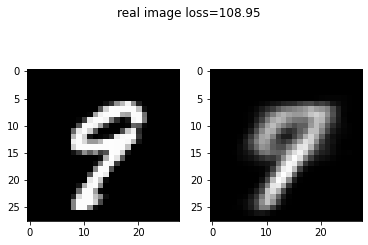

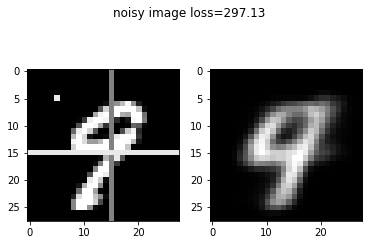

In [40]:

plt.subplot(1, 2, 1)
plt.suptitle(f'real image loss={loss_img:2.2f}')
plt.imshow(cvt2image(img), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(cvt2image(img_recon), cmap="gray")
plt.show()

plt.subplot(1, 2, 1)
plt.suptitle(f'noisy image loss={loss_rand:2.2f}')
plt.imshow(cvt2image(rand), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(cvt2image(rand_recon), cmap="gray")
# You can see it's removed the noise that we added, but retained the digit

# Solution to Exercises

## Exercise 1
<details><summary>Solution</summary>

```Python
    
# Part 1
p = Normal(0, 1)
kld_close = torch.distributions.kl.kl_divergence(p, Normal(0, 1))
kld_far = torch.distributions.kl.kl_divergence(p, Normal(10, 1))
print(kld_close, kld_far)
print('close is lower?', kld_close<kld_far)
    
# Part 2: Plot the KLD as you vary the mean of q
p = Normal(0, 1)
means = np.arange(-10, 11)

klds=[]
for mean in means:
    q = Normal(mean, 1)
    kld = torch.distributions.kl.kl_divergence(p, q)
    klds.append(kld)

plt.plot(means, klds)
plt.ylabel('KLD(p|q)')
plt.xlabel('mean of Q')
plt.show()
```

</details>

## Exercise 2
<details><summary>Solution</summary>

```Python   
 
class DeeperVAE(nn.Module):
    """Deeper Variational Autoencoder"""
    def __init__(self):
        super(DeeperVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 80),
            nn.ReLU(),
            nn.Linear(80, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 80),
            nn.ReLU(),
            nn.Linear(80, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        """Takes in image, output distribution"""
        h = self.encoder(x)
        # first few features are mean
        mean = h[:, :2]
        # second two are the log std
        log_std = h[:, 2:]
        std = torch.exp(log_std)
        # return a normal distribution with 2 parameters
        return Normal(mean, std)

    def decode(self, z):
        """Takes in latent vector and produces image."""
        return self.decoder(z)

    def forward(self, x):
        """Combine the above methods"""
        dist = self.encode(x.view(-1, 784))
        z = dist.rsample() # sample, with gradient
        return self.decode(z), dist
    
model = DeeperVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
# training loop
epochs = 10
for epoch in tqdm(range(1, epochs + 1)):
    train(epoch,loss_bce_kld)
    test(epoch,loss_bce_kld)

# visualisations
model.eval()
mu , logvar = model.encode(ds_train[:1000].to(device))
mu = mu.cpu().detach().numpy()
for i in range(10):
    idx = ds_train.y[:1000]==i
    plt.scatter(mu[idx,0],mu[idx,1],label = i)
plt.legend()

```

</details>

## Exercise 3

<details><summary>Solution</summary>

```Python
   
class WiderVAE(nn.Module):
    """Wider Variational Autoencoder"""
    def __init__(self):
        super(WiderVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        """Takes in image, output distribution"""
        h = self.encoder(x)
        # first few features are mean
        mean = h[:, :4]
        # second two are the log std
        log_std = h[:, 4:]
        std = torch.exp(log_std)
        # return a normal distribution with 2 parameters
        return Normal(mean, std)

    def decode(self, z):
        """Takes in latent vector and produces image."""
        return self.decoder(z)

    def forward(self, x):
        """Combine the above methods"""
        dist = self.encode(x.view(-1, 784))
        z = dist.rsample() # sample, with gradient
        return self.decode(z), dist
    
model = WiderVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
show_prediction(10, title=f"epoch={0}")
for epoch in tqdm(range(1, epochs + 1)):
    train(epoch, loss_bce_kld)
    test(epoch, loss_bce_kld)
    show_prediction(10, title=f"epoch={epoch}")

traverse(model=model, y=3, xmin=-5, xmax=5)

```

</details>

# (extra) Conv

Encoding and Decoding images is much easier with convolutions because they are aware that pixels are nearby. Lets try with convolutions and see if the loss is lower.

For animations of what convolution layers do see the animations from ["Vincent Dumoulin, Francesco Visin - A guide to convolution arithmetic for deep learning"](https://github.com/vdumoulin/conv_arithmetic).

A convolution layer, with the input below, and the output above:

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif" />

A transpose convolution layer:

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides_transposed.gif" />

                                  Kernel Shape     Output Shape    Params  \
Layer                                                                       
0_encoder.Conv2d_0               [1, 32, 4, 4]  [1, 32, 13, 13]     544.0   
1_encoder.BatchNorm2d_1                   [32]  [1, 32, 13, 13]      64.0   
2_encoder.ReLU_2                             -  [1, 32, 13, 13]         -   
3_encoder.Conv2d_3              [32, 64, 4, 4]    [1, 64, 5, 5]   32.832k   
4_encoder.BatchNorm2d_4                   [64]    [1, 64, 5, 5]     128.0   
5_encoder.ReLU_5                             -    [1, 64, 5, 5]         -   
6_encoder.Conv2d_6             [64, 128, 5, 5]   [1, 128, 1, 1]  204.928k   
7_encoder.ReLU_7                             -   [1, 128, 1, 1]         -   
8_encoder.Flatten_8                          -         [1, 128]         -   
9_fc11                                [128, 2]           [1, 2]     258.0   
10_fc12                               [128, 2]           [1, 2]     258.0   

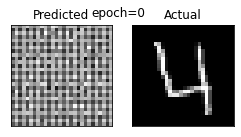

#1 Train loss: 186.6385Loss: 162.243759  
#1 Test loss: 159.3584


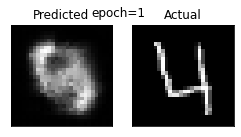

#2 Train loss: 155.5095Loss: 146.780655  
#2 Test loss: 151.8759


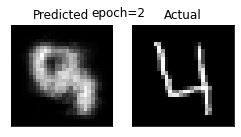

#3 Train loss: 150.7455Loss: 143.808258  
#3 Test loss: 149.4842


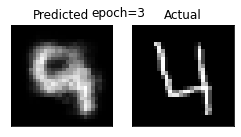

#4 Train loss: 148.1161Loss: 149.552963  
#4 Test loss: 146.7638


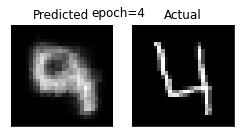

#5 Train loss: 146.4101Loss: 141.986038  
#5 Test loss: 146.5572


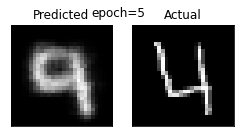

#6 Train loss: 145.1297Loss: 145.536865  
#6 Test loss: 145.2934


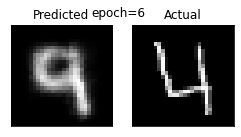

#7 Train loss: 144.1616Loss: 136.035461  
#7 Test loss: 144.1290


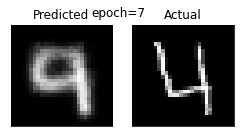

#8 Train loss: 143.2939Loss: 160.540741  
#8 Test loss: 144.2950


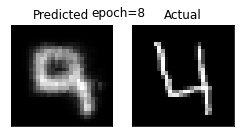

#9 Train loss: 142.6042Loss: 138.190781  
#9 Test loss: 143.2040


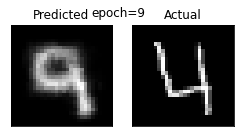

#10 Train loss: 142.0429Loss: 153.801819  
#10 Test loss: 143.3888


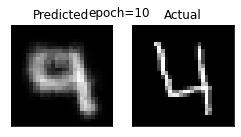

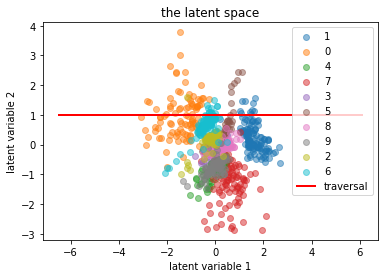

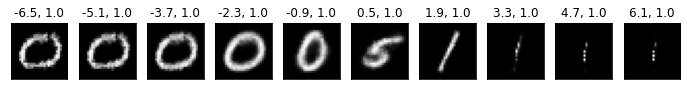

In [41]:
# Let's create our model. Same as before the model has three main sections:
class CVAE(nn.Module):
    """Convolutional VAE"""
    def __init__(self, n_latent=2):
        super(CVAE, self).__init__()
        # After each layer in the encoder we decrease the size of output and increase the number of channels. 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Flatten(),
        )

        # It acts as opposite of encoder. At each layer we increase the size of output and decrease the number of channels.
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid(),
        )

        self.fc11 = nn.Linear(128, n_latent)
        self.fc12 = nn.Linear(128, n_latent)
        self.fc2 = nn.Linear(n_latent, 128)

    def encode(self, x):
        x = x.reshape((-1, 1, 28, 28))
        h = self.encoder(x)
        mu, logvar = self.fc11(h), self.fc12(h)
        return Normal(mu, torch.exp(logvar))

    def decode(self, z):
        z = self.fc2(z)
        z = z.view(z.size(0), 128, 1, 1)
        z = self.decoder(z)
        z = z.reshape((-1, 28*28))
        return z

    def forward(self, x):
        dist = self.encode(x)
        z = dist.rsample()
        z = self.decode(z)
        return z, dist
    
model = CVAE().to(device)
from deep_ml_curriculum.torchsummaryX import summary
x = torch.randn(1, 1, 28, 28).to(device)
summary(model, x)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# training loop
epochs = 10
show_prediction(3, title=f"epoch={0}")
for epoch in tqdm(range(1, epochs + 1)):
    train_vae(epoch, loss_bce_kld, model, train_loader)
    test_vae(epoch, loss_bce_kld, model, test_loader)
    show_prediction(3, title=f"epoch={epoch}")
    
traverse(model=model, ds=ds_train, y=1)

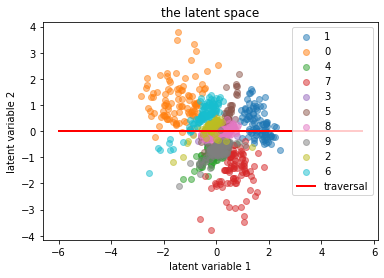

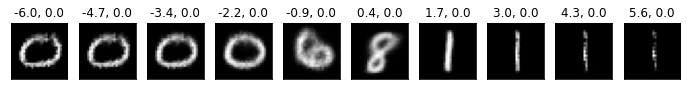

In [43]:
traverse(model=model, ds=ds_train)

# References
- [Pytorch examples for VAE](https://github.com/pytorch/examples/tree/master/vae)
- [Pytorch CelebVAE](https://github.com/AntixK/PyTorch-VAE)

# Further Reading
- [Autoencoders Explained](https://www.youtube.com/watch?v=7mRfwaGGAPg)
- [Introduction to Variational Autoencoders](https://www.youtube.com/watch?v=9zKuYvjFFS8&t=527s)
- [U-net](https://www.youtube.com/watch?v=81AvQQnpG4Q)
- [Understanding Semantic Segmentation](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47)
- [Understanding Variation Autoencoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [Visualizing MNIST using a variational autoencoder](https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder)